In [2]:
# If not already installed, do: pip install pandas fastparquet
import pandas as pd

URL_DATA = 'https://storage.data.gov.my/transportation/ktmb/ets_2025.parquet'

df = pd.read_parquet(URL_DATA)
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])

print(df)

             date   time         origin    destination  ridership
0      2025-01-01  00:00     Batu Gajah     Alor Setar          1
1      2025-01-01  00:00     Batu Gajah           Arau          1
2      2025-01-01  00:00     Batu Gajah   Padang Besar          1
3      2025-01-01  00:00         Kampar   Padang Besar          2
4      2025-01-01  00:00  Tanjong Malim     Alor Setar          1
...           ...    ...            ...            ...        ...
178617 2025-05-14  01:00           Ipoh  Tasek Gelugor          1
178618 2025-05-14  01:00  Kuala Kangsar   Padang Besar          2
178619 2025-05-14  01:00        Taiping   Padang Besar          1
178620 2025-05-14  02:00   Parit Buntar           Arau          1
178621 2025-05-14  03:00  Sungai Petani           Arau          2

[178622 rows x 5 columns]


In [3]:
df_daily = df.groupby('date')['ridership'].sum().reset_index()

In [4]:
df_daily.set_index('date',inplace=True)

In [5]:
print(df_daily)

            ridership
date                 
2025-01-01      11434
2025-01-02      11010
2025-01-03      11331
2025-01-04      11286
2025-01-05      11804
...               ...
2025-05-10      12276
2025-05-11      11932
2025-05-12      12407
2025-05-13      10920
2025-05-14         30

[134 rows x 1 columns]


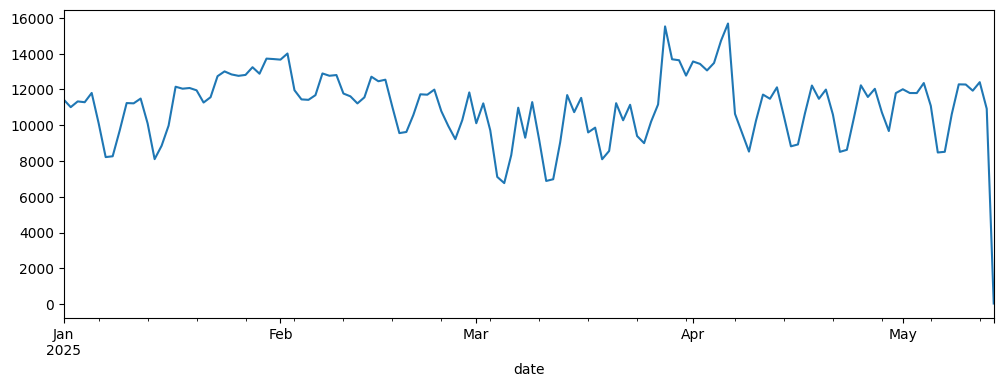

In [6]:
import matplotlib.pyplot as plt

df_daily['ridership'].plot(figsize=(12,4))
plt.show()

In [7]:
import holidays

my_holidays = holidays.MY(years=[2023,2024,2025])
df_daily['is_holiday'] = df_daily.index.to_series().apply(lambda x:x in my_holidays)

In [8]:
df_daily[df_daily['is_holiday']==True]

,ridership,is_holiday
date,,
2025-01-29,12880,True
2025-01-30,13724,True
2025-03-31,12774,True
2025-04-01,13564,True
2025-05-01,12010,True
2025-05-12,12407,True


In [9]:
df_daily['dayofweek'] = df_daily.index.dayofweek # 0 = Monday, 6 = Sunday

ADF

In [10]:
# check for linearity
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_daily['ridership'])
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

# The ADF test helps determine if a time series is stationary or non-stationary. Stationarity is a key assumption for many time series models and forecasting techniques.
# If a time series is non-stationary, its statistical properties (like mean and variance) change over time, making it unsuitable for certain models. 

Augmented Dickey-Fuller (ADF):  -2.5792804794998414
p-value:  0.0973556294693444


| Term                            | Meaning                                                                                    |
| ------------------------------- | ------------------------------------------------------------------------------------------ |
| **ADF Statistic**               | The test statistic. The more negative, the stronger the evidence against non-stationarity. |
| **p-value**                     | If **< 0.05**, we reject the null hypothesis. That means the data is **stationary**.       |
| **Null Hypothesis (H₀)**        | The series **has a unit root** → i.e., it is **non-stationary**.                           |
| **Alternative Hypothesis (H₁)** | The series is **stationary**.                                                              |


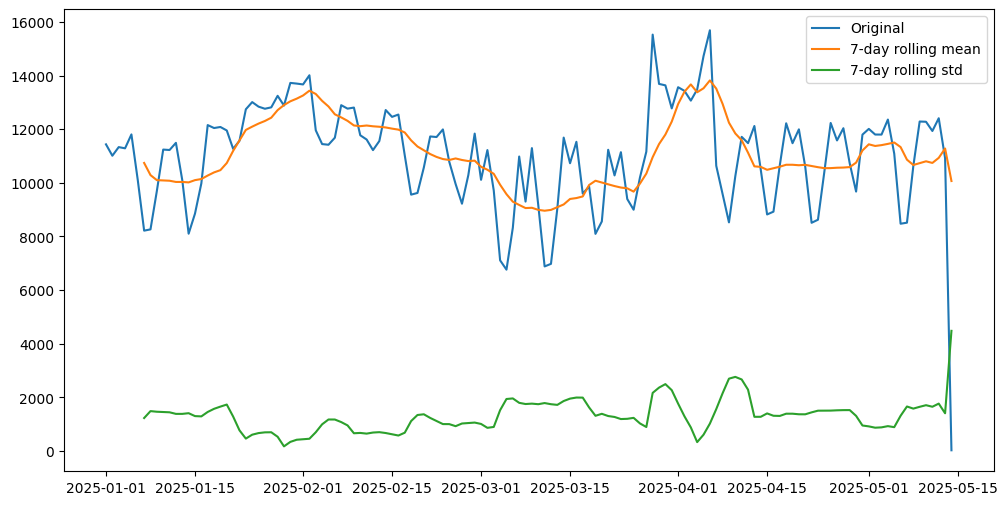

In [11]:
#plot moving average

df_daily['rolling_mean'] = df_daily['ridership'].rolling(window=7).mean()
df_daily['rolling_std'] = df_daily['ridership'].rolling(window=7).std()

plt.figure(figsize=(12,6))
plt.plot(df_daily['ridership'],label='Original')
plt.plot(df_daily['rolling_mean'], label='7-day rolling mean')
plt.plot(df_daily['rolling_std'],label='7-day rolling std')
plt.legend()
plt.show()

Original Line (Blue or solid)
→ This is the actual ridership on Jan 15.
For example: if the y-axis shows 6,000, then 6,000 people used the system that day.

Rolling Mean Line (e.g., orange or dashed)
→ This shows the average ridership over the previous 7 days leading up to Jan 15 (i.e., Jan 9 to Jan 15).
If the orange line is at 5,800, it means on average, about 5,800 people used the LRT each day in the last week.

Rolling Std Dev Line (e.g., green or dotted)
→ This line tells you how much variation there was in daily ridership in that same 7-day window.
If it’s low, ridership was steady. If it’s high, ridership was bouncing up and down.

Summary
- Our data is non-stationary it has trends and seasonality, ADF null hypothesis is accepted.
- Our earlier line graph with rolling mean and std dev already hinted this (they weren’t stable).
- Our seasonal spikes (likely due to holidays, weekdays, etc.) reinforce this.

This aligns with real-world transport data, behavior is usually not constant over time.

Removing holiday date

In [12]:
# lets try to remove holidays
df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]

result = adfuller(df_daily_non_holiday['ridership'])
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -2.4292878926831394
p-value:  0.13364014707666322


Differencing

In [13]:
# lets try to remove holidays
df_daily_non_holiday = df_daily[df_daily['is_holiday'] == False]
df_daily_non_holiday['diff'] = df_daily_non_holiday['ridership'].diff().dropna()


result = adfuller(df_daily_non_holiday['diff'].dropna())
print("Augmented Dickey-Fuller (ADF): ", result[0])
print("p-value: ", result[1])

Augmented Dickey-Fuller (ADF):  -2.9935265443938164
p-value:  0.035503377967198484


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13884\2563570960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_non_holiday['diff'] = df_daily_non_holiday['ridership'].diff().dropna()


Model identification
When we build an ARIMA model, we have to consider the p, d, and q terms that go into our ARIMA model. 

- The first parameter, p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation. We do this by looking at the autocorrelations of our time series, which are the correlations in our series at previous time lags. 
- The second parameter, d, refers to the order of differencing, which we talked about. Again, differencing simply means finding the differences between consecutive timesteps. It is a way to make our data stationary, which means removing the trends and any changes in variance over time. d indicates differencing at which order you get a process stationary.
- The third parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model. Unlike a simple moving average, which smooths data, the moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations.

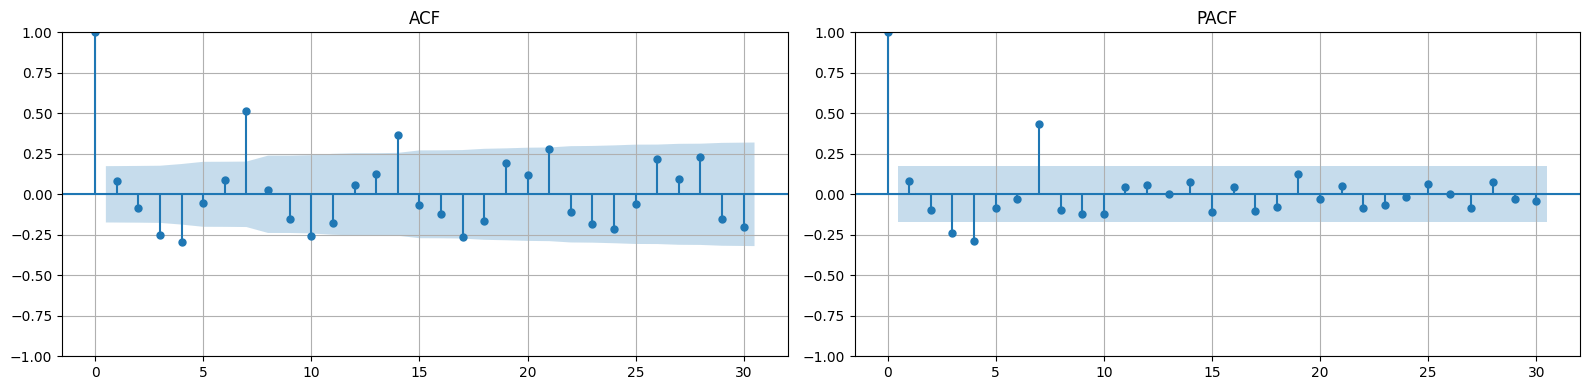

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df_daily_non_holiday['diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title("ACF")
axes[0].grid(True)


plot_pacf(df_daily_non_holiday['diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title("PACF")
axes[1].grid(True)

plt.tight_layout()
plt.show()

- p (looks at past values): (Interprest PACF) How far we should go back to make prediction on current observation: PACF cuts off at 7, p = 7
- d: At which order to get a process stationary, d = 1
- q (looks at past forecast errors): (Interpret ACF), weekly seasonality, suggested to use SARIMA model instead

PACF remove the indirect correlations which ACF shows stacking correlations (due to compounding)

How to Read the ACF Plot
X-axis (lags):

Represents how many time steps (lags) back you're comparing your current value to.

Example: Lag 7 means you're comparing today's ridership to the value 7 days ago.

Y-axis (autocorrelation value):

Shows the correlation coefficient between the time series and its lagged version.

Values range between -1 and 1:

1.0 → Perfect positive correlation.

0.75 → Strong positive correlation.

0.0 → No correlation.

-0.75 → Strong negative correlation.

IN PACF, AT LAGS 7 IT SPIKES THE HIGHEST THIS SHOW STRONG CORRELATION OF TODAY WITH 7 DAYS AGO

As can be seen Lag=19 shows highest spike compared to other positive spike, this behavorial need to be furthered study

Moving average

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13884\724101919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_non_holiday['rolling_mean'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).mean()
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13884\724101919.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_non_holiday['rolling_std'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).std()


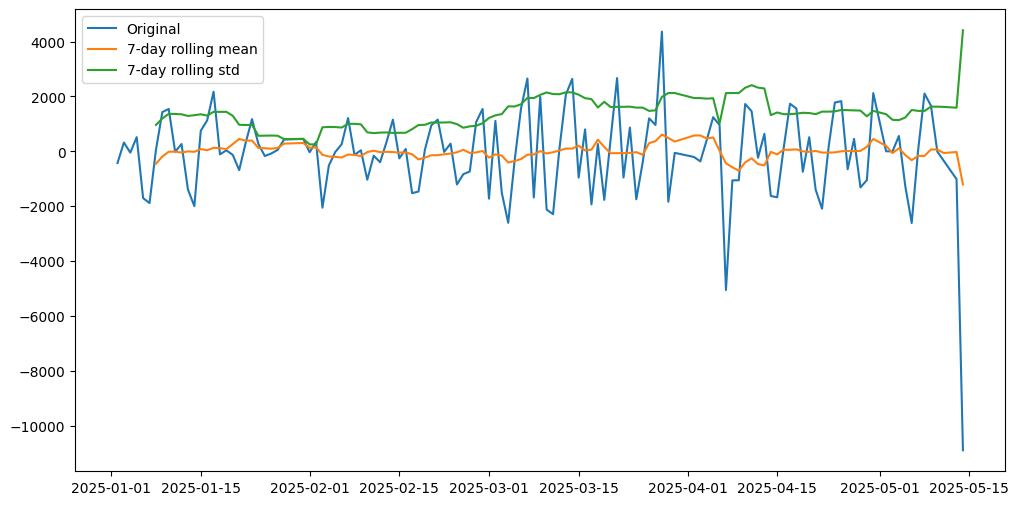

In [15]:
#plot moving average

df_daily_non_holiday['rolling_mean'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).mean()
df_daily_non_holiday['rolling_std'] = df_daily_non_holiday['diff'].dropna().rolling(window=7).std()

plt.figure(figsize=(12,6))
plt.plot(df_daily_non_holiday['diff'].dropna(),label='Original')
plt.plot(df_daily_non_holiday['rolling_mean'], label='7-day rolling mean')
plt.plot(df_daily_non_holiday['rolling_std'],label='7-day rolling std')
plt.legend()
plt.show()